In [4]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Load the model

In [24]:
weights_dir = "../../../model_weights/model_2020-04-26_21-30-34.h5"

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 512
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data

In [26]:
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
errors_dir = '../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl'

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

# Try reconstruction

In [279]:
try_first_x = 2
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    
plot_index = np.copy(try_first_x)-1

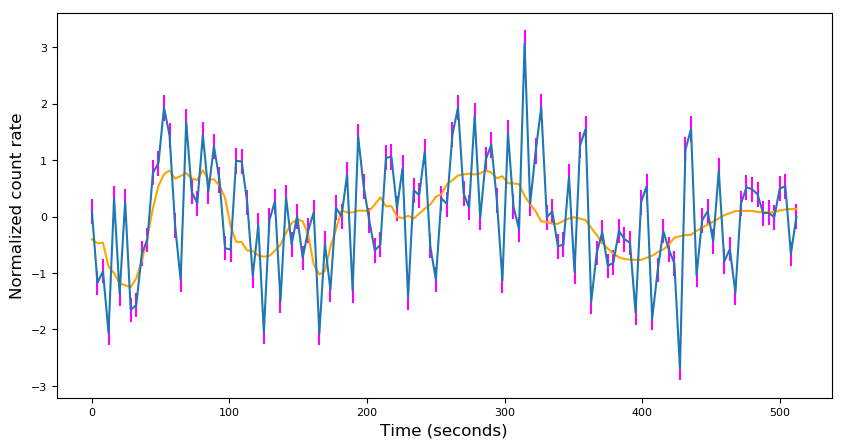

In [280]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams.update({'font.size': 8})

plt.errorbar(np.linspace(0,512, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,512, 128), reconstructions[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=12)
plt.xlabel("Time (seconds)", fontsize=12)
plt.show()
if plot_index>0:
    plot_index-=1

# Encode the data set

In [123]:
trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
segment_encoding = np.zeros((segments.shape[0], 2, 16))
for seg_ind, seg in enumerate(segments):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

468201


In [131]:
# with open('../../../data_GRS1915/segment_encoding_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0]), 'wb') as f:
#     pickle.dump(segment_encoding, f)

# UMAP the encoded data

In [5]:
with open('../../../data_GRS1915/segment_encoding_model_2020-04-26_21-30-34_segments_468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
    segment_encoding = pickle.load(f)

In [ ]:
UMAP_mapper = umap.UMAP(n_neighbors=50, min_dist=0.0)
UMAP_mapper.fit(segment_encoding[:,0,:])


In [ ]:
# with open('../../../data_GRS1915/UMAPmapper_means_segment_encoding_model_2020-04-26_21-30-34_segments_468202_len128_s2_4cad_counts_errorfix.pkl', 'wb') as f:
#     pickle.dump(UMAP_mapper, f)

In [11]:
with open('../../../data_GRS1915/UMAPmapper_means_segment_encoding_model_2020-04-26_21-30-34_segments_468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
    UMAP_mapper = pickle.load(f)

In [12]:
umaped_data = UMAP_mapper.transform(segment_encoding[:,0,:])

In [18]:
(np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)

-19.72975254058838

In [19]:
(np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)

-14.472730159759521

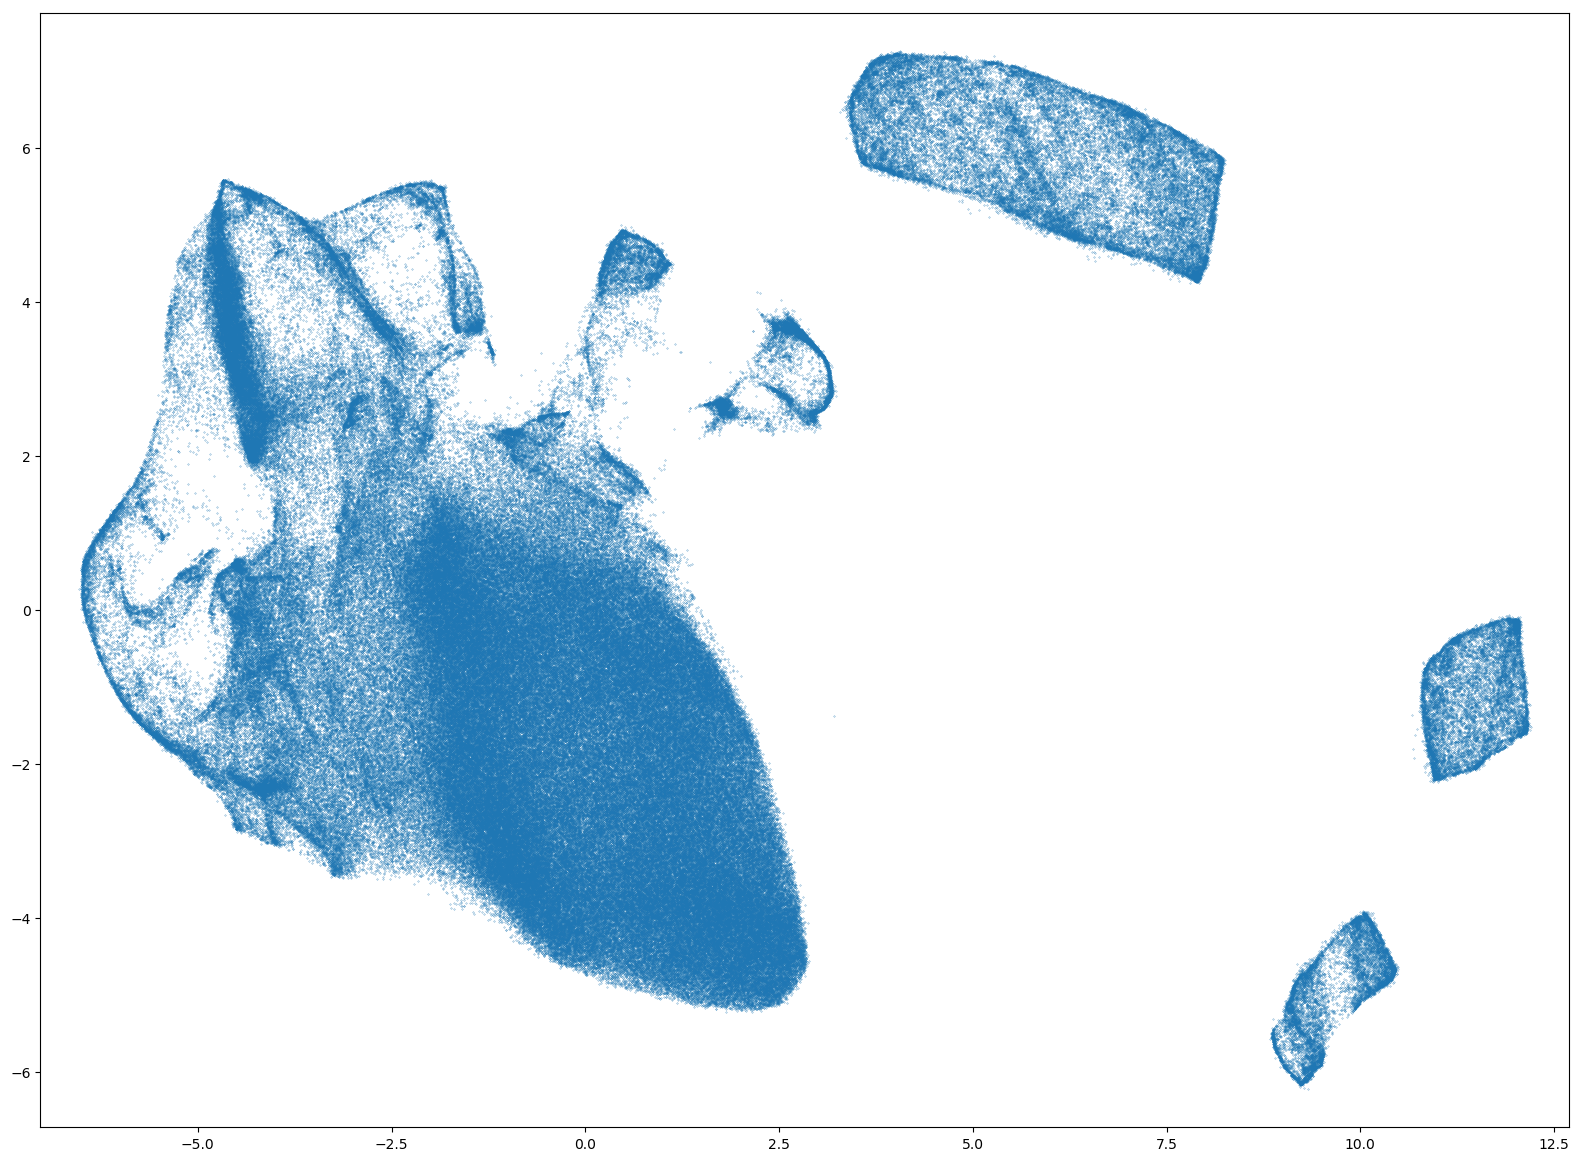

In [21]:
plt.rcParams['figure.figsize'] = (abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=0.05)
plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.show()

# Cluster the latent space

In [111]:
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=4, covariance_type='full')
clf.fit(segment_encoding[:,0,:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [112]:
custer_labels = clf.predict(segment_encoding[:,0,:])

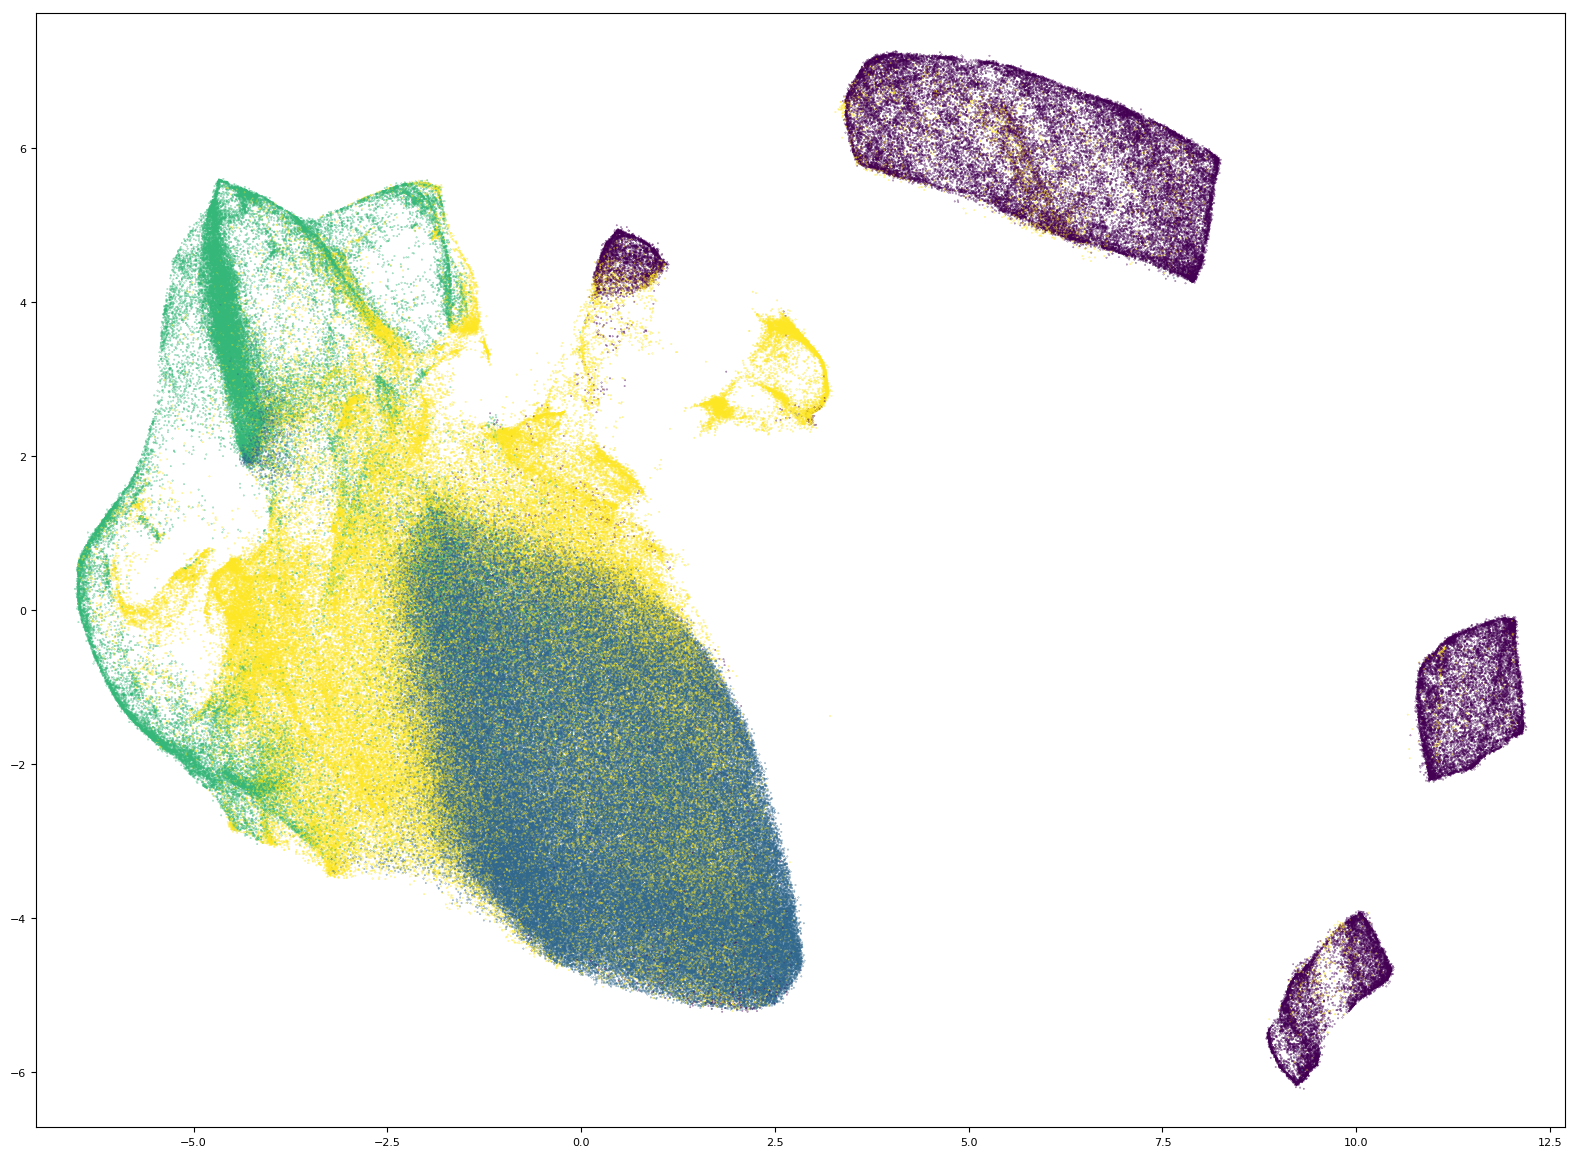

In [114]:
plt.rcParams['figure.figsize'] = (abs((np.min(umaped_data[:,0])-0.5) -(np.max(umaped_data[:,0])+0.5)), abs((np.min(umaped_data[:,1])-0.5)- (np.max(umaped_data[:,1])+0.5)))
plt.scatter(umaped_data[:,0], umaped_data[:,1], s=0.05, c=custer_labels)
plt.xlim([np.min(umaped_data[:,0])-0.5, np.max(umaped_data[:,0])+0.5])
plt.ylim([np.min(umaped_data[:,1])-0.5, np.max(umaped_data[:,1])+0.5])
plt.show()

# Overplot the classified data

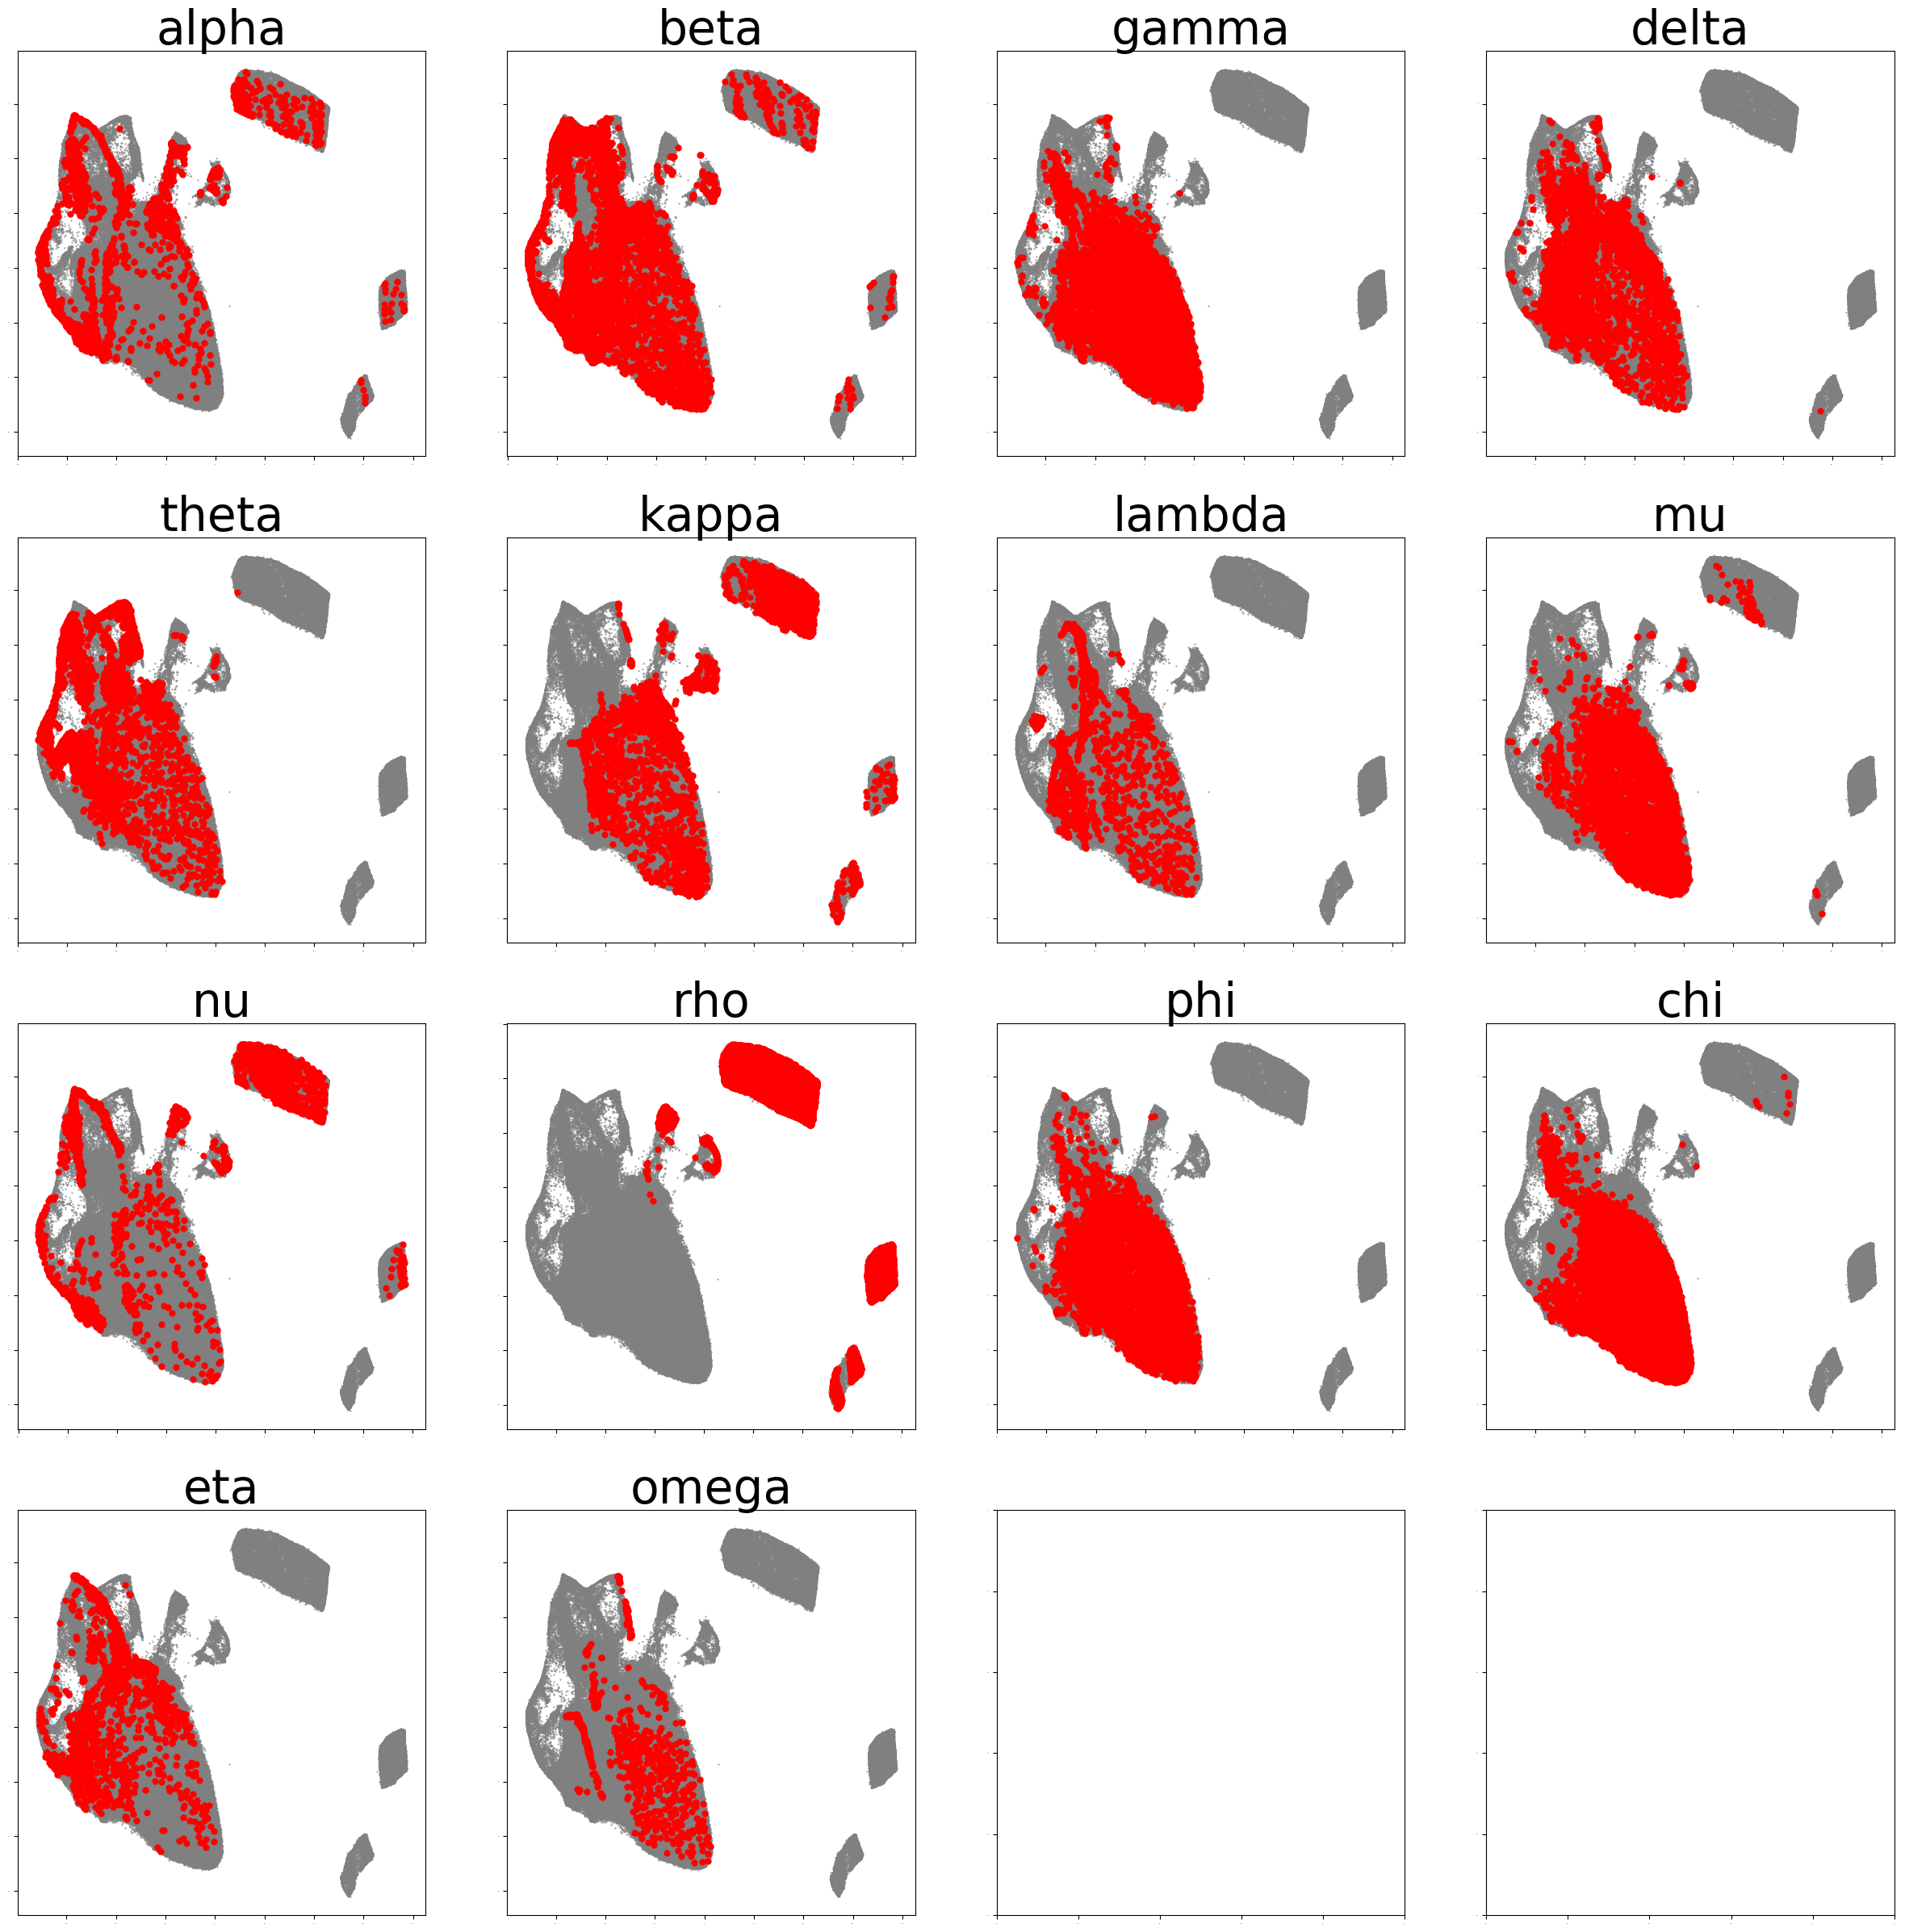

In [22]:
# load observation classifications from Huppenkothen 2017
# %matplotlib inline

# import matplotlib.pyplot as plt


clean_belloni = open('../../../data_GRS1915/1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
# load segmented light curves

import pickle
with open('../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
    seg_ids = pickle.load(f)

# # HF QPO observation ids
# paper_obIDs = np.loadtxt("../../../data_GRS1915/Belloni_Altamirano_obsIDs.txt", dtype=str)

# qpo_colours = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_colours.append("red")
#     else:
#         qpo_colours.append("grey")
        
# qpo_labels = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_labels.append("QPO")
#     else:
#         qpo_labels.append("other")
        
        
# qpo_scales = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_scales.append("QPO")
#     else:
#         qpo_scales.append("other")
        
        
xxx = [seg.split("_")[0] for seg in seg_ids]

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_colour = []
for ob in xxx:
    if ob in ob_state:
        class_colour.append(np.where(classes == ob_state[ob])[0][0])
    else:
        class_colour.append(15)
        
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
class_name = []
for ob in xxx:
    if ob in ob_state:
        class_name.append(ob_state[ob])
        scales.append(5)
    else:
        class_name.append("Unknown")
        scales.append(0.1)
        
        
from matplotlib import cm
cm.get_cmap(plt.get_cmap("Set1"))


colours = ['#ffd8b1', '#000075', '#808080', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#000000']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# sns.set_style("white")
plt.rcParams['figure.figsize'] = (30.0, 30.0)
plt.rcParams.update({'font.size': 0})

embeddings_lap = umaped_data

# fig, ax = plt.subplots()

fig, axs = plt.subplots(4, 4)
axs = axs.flatten()

for plot_class_ind, plot_class in enumerate(classes):
    class_indices = np.where(np.array(class_name) == "Unknown")[0]
    class_data = embeddings_lap[class_indices]
    axs[plot_class_ind].scatter(class_data[:,0], class_data[:,1], s = 0.2, c="grey", label="Unknown")

    class_indices = np.where(np.array(class_name) == plot_class)[0]
    class_data = embeddings_lap[class_indices]
    
    axs[plot_class_ind].scatter(class_data[:,0], class_data[:,1], s = 25, c='red', label=plot_class)
    
# plt.legend()
    axs[plot_class_ind].set_title("{}".format(plot_class), fontsize=42)
axs.reshape((4,4))
# plt.savefig("classes_separate.png")

# plt.savefig("UMAP_embedding_separate_classes_model_2020-02-09_10-36-06.png")
plt.show()


# redint = np.where(np.array(qpo_colours) == "red")
# greyint= np.where(np.array(qpo_colours) != "red")
# plt.scatter(embeddings_lap[:,0][greyint], embeddings_lap[:,1][greyint], s=1, c="grey", label= "other")
# plt.scatter(embeddings_lap[:,0][redint], embeddings_lap[:,1][redint], s=1, c="red", label= "HF QPO")
# plt.title("UMAP embedding of the encoded GRS1915 segments, neighbors=50, min_dist=0.0, components=2", fontsize=12)
# plt.legend()
# plt.show()

# Histogram reconstruction

In [2]:
with open('../../../data_GRS1915/468202_len128_s2_4cad_histograms_24bin_0-13k_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
# with open('../../data_GRS1915/94465_len512_s40_errors_errorfix.pkl', 'rb') as f:
#     errors = pickle.load(f)
    
# errors = ((errors)/np.std(segments)).astype(np.float32)
segments = zscore(segments, axis=None).astype(np.float32)  # standardize


y_in = Input(shape=(24,1))
# y_err = Input(shape=(512,1))
# h_enc = Conv1D(32, 2, activation='relu')(y_in)
# h_enc = Conv1D(32, 8, activation='relu')(h_enc)
# h_enc = CuDNNGRU(512, return_sequences=True)(y_in)
# h_enc = CuDNNGRU(256, return_sequences=True)(y_in)
h_enc = CuDNNLSTM(256, return_sequences=False)(y_in)
# h_enc = Dense(256)(h_enc)
h_enc = Dense(8, activation=None, name='bottleneck')(h_enc)
# h_enc = BatchNormalization()(h_enc)
h_dec = RepeatVector(24)(h_enc)
h_dec = CuDNNLSTM(258, return_sequences=True)(h_dec)
# h_dec = CuDNNGRU(256, return_sequences=True)(h_dec)
h_dec = TimeDistributed(Dense(1))(h_dec)
model = Model(inputs=[y_in], outputs=h_dec)

model.load_weights("../../../model_weights/model_2020-04-27_15-19-48.h5")




In [7]:
try_first_x = 20
hist_reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    hist_reconstructions[segment_index] = model.predict(np.expand_dims(segment, axis=0)).flatten()
    
plot_index = np.copy(try_first_x)-1

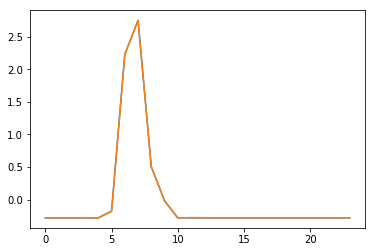

In [31]:
plt.plot(segments[plot_index])
plt.plot(hist_reconstructions[plot_index])
plt.show()
if plot_index>0:
    plot_index-=1

In [42]:
weights_dir = "../../../model_weights/model_2020-04-27_15-04-21.h5"

In [45]:
with open('../../../data_GRS1915/468202_len128_s2_4cad_histograms_24bin_0-13k_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
# with open('../../data_GRS1915/94465_len512_s40_errors_errorfix.pkl', 'rb') as f:
#     errors = pickle.load(f)
    
# errors = ((errors)/np.std(segments)).astype(np.float32)
segments = zscore(segments, axis=None).astype(np.float32)  # standardize


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

original_dim = 24
intermediate_dim = 64
latent_dim = 10

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name='vae')


vae.load_weights(weights_dir)

In [46]:
try_first_x = 20
hist_reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    hist_reconstructions[segment_index] = vae.predict(np.expand_dims(segment, axis=0)).flatten()
    
plot_index = np.copy(try_first_x)-1

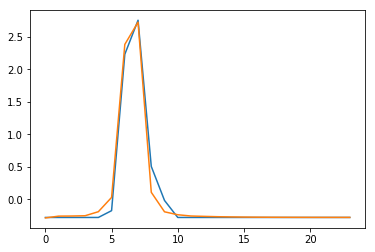

In [74]:
plt.plot(segments[plot_index])
plt.plot(hist_reconstructions[plot_index])
plt.show()
if plot_index>0:
    plot_index-=1